# Figure 8: Effect of Diffusion Constants on Turing Pattern Formation

## Introduction
In this notebook, we analyse the effect of diffusion constants $D_X$, $D_Y$ on Turing pattern formation.

The notebook serves as a tutorial for the *figure8_re_v3.py* script.

The script generates all 4 figures simultaneously, whereas here we plot them one by one.
***
***

## Code

### 1. Import Libraries

In [9]:
import pandas as pd
import numpy as np
import os
from scipy.signal import argrelextrema
import time
from multiprocessing.pool import ThreadPool
import matplotlib.pyplot as plt

### 2. Define Functions

First, we define the random matrix generating function *gen_matrix_F()* with parameters *n* (network size) and *vr* (variance).

In [10]:
def gen_matrix_F(n,vr):
    I = np.eye(n)
    mu = 0
    B = mu + np.sqrt(vr) * np.random.randn(n, n)
    np.fill_diagonal(B, 0)
    A = -I + B
    D = np.zeros((n, n))
    return A, D

Next, we define *process_tuple()* function which computes the Turing I percentage for each case (tuplet): $(D_{x_1}, D_{y_1}), (D_{x_2}, D_{y_2}), ..., (D_{x_n}, D_{y_n})$.

The function returns percentage of observed Turing I instability for a given diffusion constant pair.

Note:
- In this example, 1,000 matrices are generated for each $(D_x, D_y)$ pair. This number can be changed in the first for loop of the function.
- In order to compute and visualise all 4 cases (N =3,4,10,50) simultaneously, we pass ((*N*,$σ^2$), $D_{x}$, $D_{y}$) to the function. <br>
$(N,σ^2)$ part is assigned to a variable *p* which is fed to *gen_matrix_F()* function.
- In this example, we use slightly adjusted mesh *k = np.arrange(0, 10, 0.1)* for simplicity. In the *figure8_re_v3.py* script, *k = np.arrange(0, 10, 0.01)*


In [11]:
def process_tuple(tuplet):
    p,x,y = tuplet

    D = gen_matrix_F(p[0],p[1])[1]
    D[0, 0] = 10**x
    D[1, 1] = 10**y
    k = np.arange(0, 10, 0.1)

    t1a = []
    t1b = []
    t2a = []
    t2b = []


    for i in range(1000): # 1,000 matrices
        m = gen_matrix_F(p[0],p[1])[0]
        ev = np.linalg.eigvals(m)
        if np.max(np.real(ev)) < 0:    # if matrix is stable
            Em = []
            Emi = []
            for i in range(len(k)):
                R = m - D * (k[i] ** 2)
                eigval = np.linalg.eigvals(R)
                Em.append(np.max(np.real(eigval)))
                idx_max = np.argmax(np.real(eigval))
                Emi.append(np.imag(eigval[idx_max]))
            a = np.max(Em)
            index = np.argmax(Em)
            nEm = np.array(Em)
            if a > 0:
                if Emi[index] == 0:
                    numZeroCrossing = np.count_nonzero(np.diff(np.sign(Em)))  # Count zero crossings
                    numpositivelocalmaxima = np.sum(nEm[argrelextrema(nEm,np.greater)]>0) > 0
                    if numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 0:
                        t1a.append(m)
                    elif numpositivelocalmaxima > 0 and numZeroCrossing == 1:
                        t1b.append(m)
                    elif numpositivelocalmaxima == 0 and numZeroCrossing % 2 == 1:
                        t2a.append(m)
                    elif numpositivelocalmaxima > 0 and numZeroCrossing % 2 == 1:
                        t2b.append(m)
    percent = (len(t1a)+len(t1b))*0.1

    return percent

### 3. Set Parameters
This is where the diffusion constants and network size-variance pairs are intialised.


In this notebook, a coarser grid is used with the increment of 0.5. A finer grid is used in the *figure8_re_v3.py* script.

The diffusion constant increment can be adjusted here as needed for more accuracy.

In [12]:
# diffusion constants
dx = [-3,-2,-1,0,1,2,3]
dy = [-3,-2,-1,0,1,2,3]

The *params* variable represents cases we want to visualise (N, var).

In this notebook, we define and plot each case separately.

In the script, the parameters are defined as *parameters = [(3, 1), (4, 1), (10, 0.2), (50, 0.02)]*

The variance is picked in line with $σ^2$ = $\frac{1}{N}$ (refer to Figure 7).
- *N* = 3,  $σ^2$ = 1
- *N* = 4,  $σ^2$ = 1
- *N* = 10,  $σ^2$ = 0.2
- *N* = 50,  $σ^2$ = 0.02

In [13]:
# network size n and matrix variance vr
params3 = [(3, 1)]  # (N, var)
params4 = [(4, 1)]
params10 = [(10, 0.2)]
params50 = [(50, 0.02)]

### 4. Generate and Visualise Data

In this cell, we compute our data by calling the *process_tuple()* function defined above and by using multithreading. <br><br>

<span style="color:red">Note 1</span>: A finer grid is used in the figure8_RE_v3.py file

<span style="color:red">Note 2</span>: ThreadPool python is not actually running multiple processes in parallel but instead is running multiple threads in parallel. ThreadPool is used here because it is compatible with the Jupyter Notebooks. In the *figure8_re_v3.py* script, we use *multiprocessing* package.

### *N = 3*

In [5]:
dp_list = [(par, x, y) for par in params3 for x in dx for y in dy]
start_time = time.time()
# Number of cores to use
num_cores = 2

# creating multiprocessing pool
pool = ThreadPool(processes=num_cores)

# using the pool to apply the process_tuple function to each tuple in the list
results = pool.map(process_tuple, dp_list)
# Close the pool
pool.close()
pool.join()

end_time = time.time()

df_data = pd.DataFrame({'N': [x[0][0] for x in dp_list], 'Dx': [x[1] for x in dp_list], 'Dy': [x[2] for x in dp_list], 'Percentage': results})
df_data.to_csv(os.path.join('./', 'heatmap3_fig8.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Total execution time: 253.53 seconds


After running the above cell, we obtain the following dataframe with 4 columns (N, $D_x$, $D_y$, Turing I percentage):

This dataframe is saved as a csv file.

In [6]:
# N = 3
path3 = './heatmap3_fig8.csv'
data3 = pd.read_csv(path3)
data3.head()

,N,Dx,Dy,Percentage
0,3,-3,-3,0.0
1,3,-3,-2,0.0
2,3,-3,-1,0.2
3,3,-3,0,2.9
4,3,-3,1,2.0


Creating new dataframes based on unique *N* values.

In [7]:
# N = 3
df_n3 = data3[data3['N'] == 3]
per3 = np.array(df_n3['Percentage'])
l = len(dx)
percentage3 = [per3[i:i+l] for i in range(0, len(per3), l)]

Plotting the heat map

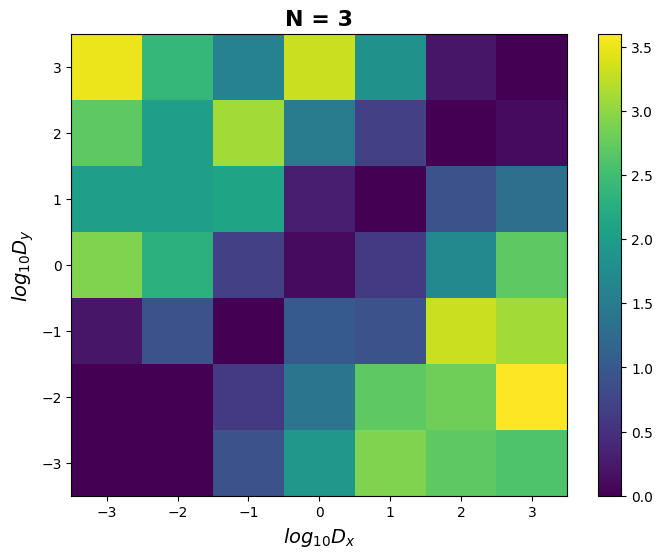

In [8]:
Y, X = np.meshgrid(dy, dx)
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage3, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 3', fontsize = 16,  fontweight = 'bold')
plt.show()

***


***

Next, we generate and visualise data for *N* = 4, 10, and 50.

Note: In *figure8_re_v3.py* script, the plots are produced simultaneously.

### *N* = 4

Total execution time: 189.69 seconds


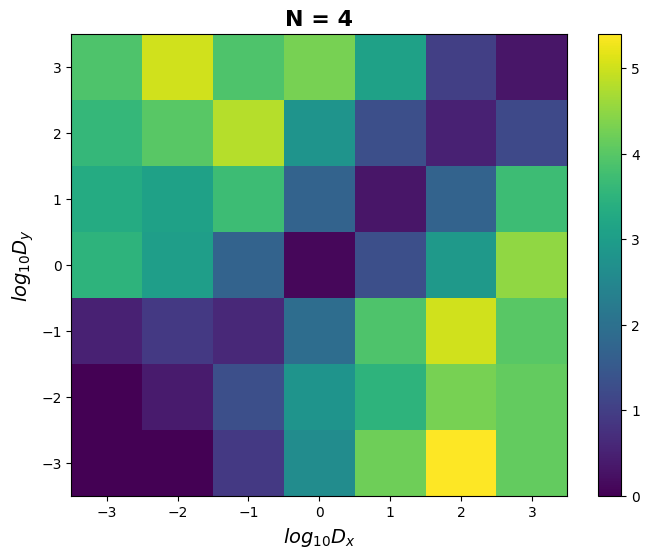

In [15]:
dp_list = [(par, x, y) for par in params4 for x in dx for y in dy]
start_time = time.time()
# Number of cores to use
num_cores = 2

# creating multiprocessing pool
pool = ThreadPool(processes=num_cores)

# using the pool to apply the process_tuple function to each tuple in the list
results = pool.map(process_tuple, dp_list)
# Close the pool
pool.close()
pool.join()

end_time = time.time()

df_data = pd.DataFrame({'N': [x[0][0] for x in dp_list], 'Dx': [x[1] for x in dp_list], 'Dy': [x[2] for x in dp_list], 'Percentage': results})
df_data.to_csv(os.path.join('./', 'heatmap4_fig8.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")


path4 = './heatmap4_fig8.csv'
data4 = pd.read_csv(path4)

df_n4 = data4[data4['N'] == 4]
per4 = np.array(df_n4['Percentage'])
l = len(dx)
percentage4 = [per4[i:i+l] for i in range(0, len(per4), l)]


Y, X = np.meshgrid(dy, dx)
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage4, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 4', fontsize = 16,  fontweight = 'bold')
plt.show()

***

### *N* = 10

Total execution time: 235.62 seconds


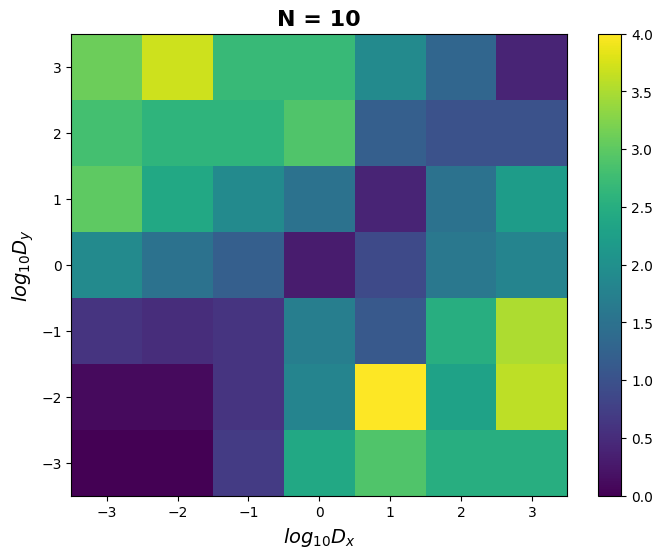

In [18]:
dp_list = [(par, x, y) for par in params10 for x in dx for y in dy]
start_time = time.time()
num_cores = 2

pool = ThreadPool(processes=num_cores)
results = pool.map(process_tuple, dp_list)
pool.close()
pool.join()

end_time = time.time()

df_data = pd.DataFrame({'N': [x[0][0] for x in dp_list], 'Dx': [x[1] for x in dp_list], 'Dy': [x[2] for x in dp_list], 'Percentage': results})
df_data.to_csv(os.path.join('./', 'heatmap10_fig8.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")


path10 = './heatmap10_fig8.csv'
data10 = pd.read_csv(path10)

df_n10 = data10[data10['N'] == 10]
per10 = np.array(df_n10['Percentage'])
l = len(dx)
percentage10 = [per10[i:i+l] for i in range(0, len(per10), l)]

Y, X = np.meshgrid(dy, dx)
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage10, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 10', fontsize = 16,  fontweight = 'bold')
plt.show()

***

### *N* = 50

Total execution time: 3981.76 seconds


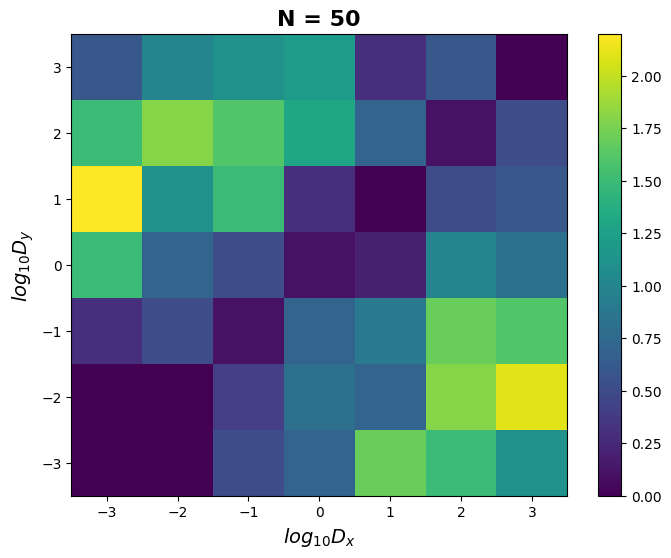

In [19]:
dp_list = [(par, x, y) for par in params50 for x in dx for y in dy]
start_time = time.time()
num_cores = 2


pool = ThreadPool(processes=num_cores)
results = pool.map(process_tuple, dp_list)
pool.close()
pool.join()

end_time = time.time()

df_data = pd.DataFrame({'N': [x[0][0] for x in dp_list], 'Dx': [x[1] for x in dp_list], 'Dy': [x[2] for x in dp_list], 'Percentage': results})
df_data.to_csv(os.path.join('./', 'heatmap50_fig8.csv'), index=False)
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")



path50 = './heatmap50_fig8.csv'
data50 = pd.read_csv(path50)

df_n50 = data50[data50['N'] == 50]
per50 = np.array(df_n50['Percentage'])
l = len(dx)
percentage50 = [per50[i:i+l] for i in range(0, len(per50), l)]


Y, X = np.meshgrid(dy, dx)
plt.figure(figsize=(8, 6))
colormap = plt.pcolormesh(X, Y, percentage50, cmap='viridis')
plt.colorbar(colormap)
plt.xlabel(r'n', fontsize = 14)
plt.xlabel(r'$log_{10}$$D_{x}$', fontsize = 14)
plt.ylabel(r'$log_{10}$$D_{y}$', fontsize = 14)
plt.title('N = 50', fontsize = 16,  fontweight = 'bold')
plt.show()